In [1]:
import numpy as np

from tqdm import tqdm, trange

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

from torchvision.transforms import ToTensor
from torchvision.datasets.mnist import MNIST

np.random.seed(0)
torch.manual_seed(0)

In [2]:
import einops
from einops import rearrange, reduce, repeat
from skimage import data
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
class MyViT(nn.Module):
    def __init__(self):
        # Super constructor
        super(MyViT, self).__init__()

    def forward(self, images):
        pass

![ViT architecture](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*tA7xE2dQA_dfzA0Bub5TVw.png)

*`The architecture of the ViT with specific details on the transformer encoder and the MSA block. Keep this picture in mind. Picture from Bazi et. al.`*


## Let’s build the ViT in 6 main steps.

Step 1: Patchifying and the linear mapping

In [4]:
# def patchify(images, n_patches):
#     n, c, h, w = images.shape

#     assert h == w, "Patchify method is implemented for square images only"

#     patches = torch.zeros(n, n_patches ** 2, h * w * c // n_patches ** 2)
#     patch_size = h // n_patches

#     for idx, image in enumerate(images):
#         for i in range(n_patches):
#             for j in range(n_patches):
#                 patch = image[:, i * patch_size: (i + 1) * patch_size, j * patch_size: (j + 1) * patch_size]
#                 patches[idx, i * n_patches + j] = patch.flatten()
#     return patches

In [5]:
# import torch

# def patchify(images, n_patches):
#     n, c, h, w = images.shape

#     assert h == w, "Patchify method is implemented for square images only"

#     patch_size = h // n_patches
#     patches = images.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
#     patches = patches.contiguous().view(n, -1, c * patch_size * patch_size)

#     return patches

In [6]:


# def patchify(images, n_pathces):
#     """
#     Example:

#         x = torch.randn(1,1, 28,28)
#         rearrange(x, 'b c (h p1) (w p2) ->b p1 p2 c h w', p1=7, p2=7).shape

#         #Result: torch.Size([1, 7, 7, 1, 4, 4])

#         # We got 1 7x7 patched image totalling 49 patches, and each of the holding 4x4x1 (HxWxC) pixels.

#     """
#     b, c, h, w = images.shape
#     assert h == w, "Patchify method is implemented for square images only"
#     p1 = p2 = n_pathces

#     return rearrange(x, 'b c (h p1) (w p2) ->b (p1 p2 c) (h w)', p1=p1, p2=p2)


In [7]:
import torch
from einops import rearrange

def patchify(images, n_patches):
    n, c, h, w = images.shape

    assert h == w, "Patchify method is implemented for square images only"

    patch_size = h // n_patches

    # Rearrange the tensor to create patches directly
    patches = rearrange(images, 'n c (i p1) (j p2) -> n (i j) (c p1 p2)', i=n_patches, j=n_patches, p1=patch_size, p2=patch_size)

    return patches

In [8]:
class MyViT(nn.Module):
  def __init__(self, chw=(1, 28, 28), n_patches=7):
    # Super constructor
    super(MyViT, self).__init__()
    super().__init__()

    # Attributes
    self.chw = chw # (C, H, W)
    self.n_patches = n_patches

    assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
    assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"

  def forward(self, images):
    patches = patchify(images, self.n_patches)
    return patches

In [9]:
camera = data.camera()

In [10]:
I =Image.fromarray(camera).convert('L')

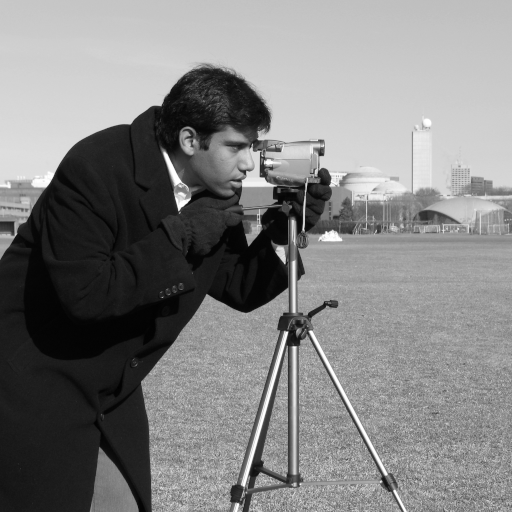

In [11]:
I

In [12]:
x = np.expand_dims(np.array(I), axis=(0, 1))
x = torch.tensor(x, dtype=torch.float16)

In [13]:
x.shape

torch.Size([1, 1, 512, 512])

In [14]:
if __name__ == '__main__':
  # Current model
  model = MyViT(
    chw=(1, 512, 512),
    n_patches=8
  )

#   x = torch.randn(7, 1, 28, 28) # Dummy images
  print(model(x).shape) # torch.Size([7, 49, 16])

torch.Size([1, 64, 4096])


In [15]:
patches = model(x)

Step 2: Adding the classification token

In [16]:

    # 2) Learnable classifiation token
    # self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))

In [64]:
class MyViT(nn.Module):
  def __init__(self, chw=(1, 28, 28), n_patches=7, hidden_d=100):
    # Super constructor
    super(MyViT, self).__init__()

    # Attributes
    self.chw = chw # (C, H, W)
    self.n_patches = n_patches
    self.hidden_d = hidden_d

    assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
    assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
    self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

    # 1) Linear mapper
    self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
    print(f"Linear in_channels -> out_channels: {(self.input_d, self.hidden_d)}")
    self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

    # 2) Learnable classifiation token
    self.class_token = nn.Parameter(torch.rand(1, 1, self.hidden_d))

  def forward(self, images):
    print(f"Images size: {images.shape}")
    patches = patchify(images, self.n_patches)
    print(f"patches shape: {patches.shape}")
    tokens = self.linear_mapper(patches)

    print(f"tokens.shape: {tokens.shape}")

    print(f"tokens, class_token.shape: {tokens.shape} , {self.class_token.shape}" )
    
    # Adding classification token to the tokens
    tokens = torch.cat([self.class_token, tokens], dim=1)
    print(f"tokens.shape after stacking: {tokens.shape}")
    return tokens

In [65]:
x.dtype

torch.float32

In [66]:
if __name__ == '__main__':
  # Current model
  model = MyViT(
    chw=(1, 28, 28),
    n_patches=7,
    hidden_d=100
  )

  x = torch.randn(1, 1, 28, 28) # Dummy images
  print(model(x).shape) # torch.Size([7, 49, 16])

Linear in_channels -> out_channels: (16, 100)
Images size: torch.Size([1, 1, 28, 28])
patches shape: torch.Size([1, 49, 16])
tokens.shape: torch.Size([1, 49, 100])
tokens, class_token.shape: torch.Size([1, 49, 100]) , torch.Size([1, 1, 100])
tokens.shape after stacking: torch.Size([1, 50, 100])
torch.Size([1, 50, 100])


In [67]:
x = np.expand_dims(np.array(I), axis=(0,1))
x = torch.tensor(x,dtype=torch.float32)
chw = tuple(x.shape[1:])

In [68]:
if __name__ == '__main__':
  # Current model
  model = MyViT(
    chw=chw,
    n_patches=8,
    hidden_d=100
  )

#   x = torch.randn(1, 1, 28, 28) # Dummy images
  print(model(x).shape) # torch.Size([7, 49, 16])

Linear in_channels -> out_channels: (4096, 100)
Images size: torch.Size([1, 1, 512, 512])
patches shape: torch.Size([1, 64, 4096])
tokens.shape: torch.Size([1, 64, 100])
tokens, class_token.shape: torch.Size([1, 64, 100]) , torch.Size([1, 1, 100])
tokens.shape after stacking: torch.Size([1, 65, 100])
torch.Size([1, 65, 100])


In [69]:
y = model(x)

Images size: torch.Size([1, 1, 512, 512])
patches shape: torch.Size([1, 64, 4096])
tokens.shape: torch.Size([1, 64, 100])
tokens, class_token.shape: torch.Size([1, 64, 100]) , torch.Size([1, 1, 100])
tokens.shape after stacking: torch.Size([1, 65, 100])


In [70]:
1*512*512

262144

In [71]:
1*64*4096

262144

In [72]:
1*64*100

6400